<a href="https://colab.research.google.com/github/asarria48/Nuclear-physics/blob/main/Previa2ASM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import os
from io import StringIO

# Para ver un espectro

<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3993698577.py:13: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)


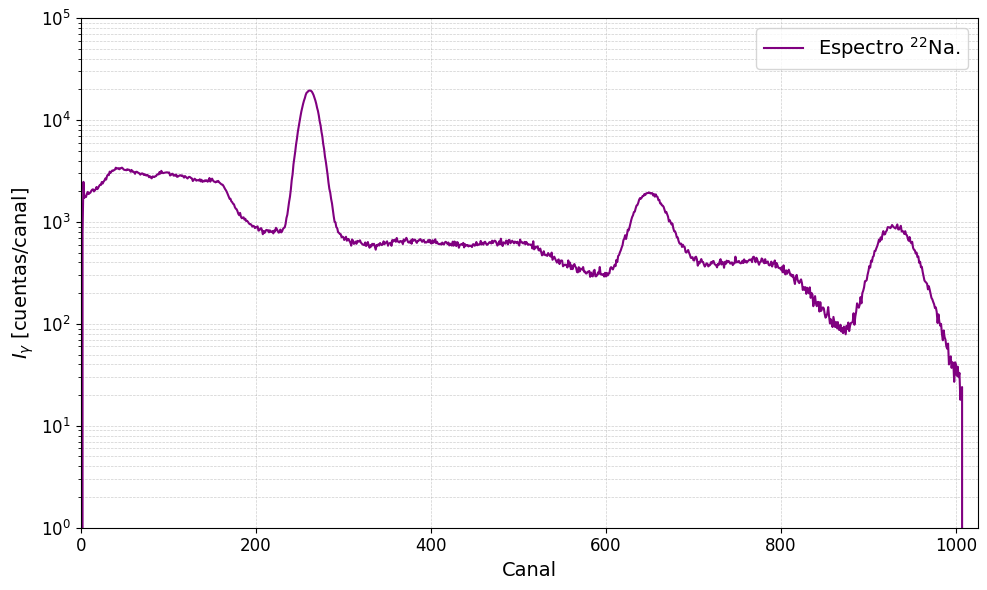

In [16]:
datos = "22Na-previa2.csv"
df = pd.read_csv(datos)

x = df.iloc[:, 0]
y = df.iloc[:, 1]

plt.figure(figsize=(10,6))
plt.plot(x, y, color='purple', lw=1.5, label="Espectro $^{22}$Na.")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.yscale('log')
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.xlim(0,1025)
plt.ylim(1e0, 1e5)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


# Para ajustar picos

<>:60: SyntaxWarning: invalid escape sequence '\g'
<>:60: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3928945507.py:60: SyntaxWarning: invalid escape sequence '\g'
  ax.set_ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)



μ        = 261.555(21)
σ        = 9.548(24)
FWHM     = 22.397(57)
Int      = 446578(14)


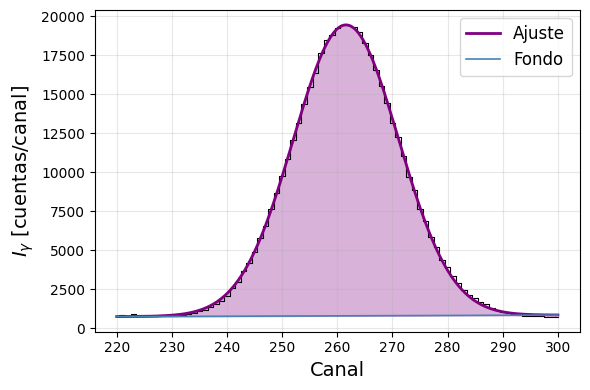


μ        = 650.02(11)
σ        = 16.95(14)
FWHM     = 39.75(33)
Int      = 66888(68)


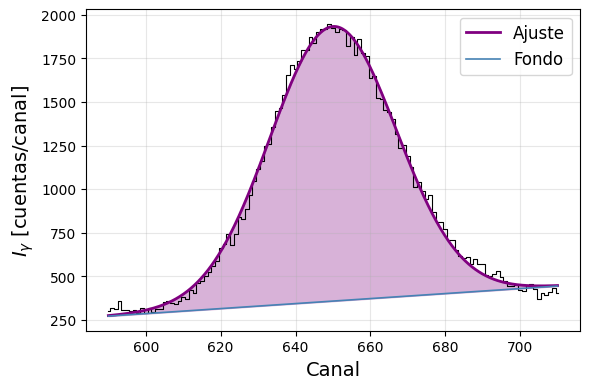


μ        = 930.83(16)
σ        = 20.23(19)
FWHM     = 47.45(45)
Int      = 42577(49)


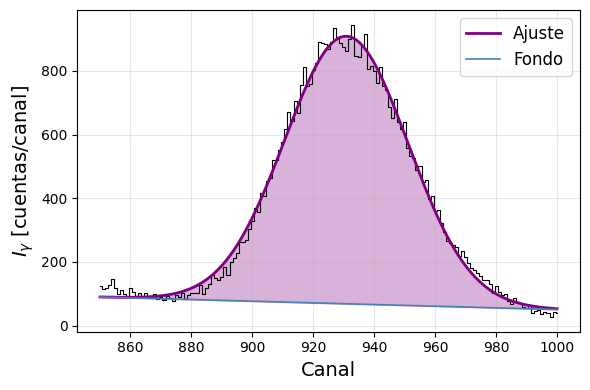

In [18]:
def gauss_bg(x, mu, sigma, A, a0, a1):                                              # gaussiana con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x

def fwhm(sigma): return 2.3458 * sigma
def dfwhm(dsigma): return 2.3458 * dsigma
def intensidad(A, sigma): return A * sigma * np.sqrt(2*np.pi)
def dintensidad(A, sigma, dA, dsigma):
    return np.sqrt((sigma*np.sqrt(2*np.pi)*dA)**2 + (A*np.sqrt(2*np.pi)*dsigma)**2)

def format_unc(value, error):
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


# ajustes en general
def ajustar_pico(x, y, x_min, x_max, color="purple"):

    mask = (x >= x_min) & (x <= x_max)
    xr, yr = x[mask], y[mask]

    mu_guess = xr.iloc[np.argmax(yr)]
    A_guess = yr.max()
    p0 = [mu_guess, 4.0, A_guess, np.median(yr), 0.0]

    popt, pcov = curve_fit(gauss_bg, xr, yr, p0=p0, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))

    mu, sigma, A, a0, a1 = popt
    dmu, dsigma, dA, da0, da1 = perr

    print(f"\n======")
    labels = ["μ", "σ", "FWHM", "Int"]
    vals   = [mu, sigma, fwhm(sigma), intensidad(A, sigma)]
    errs   = [dmu, dsigma, dfwhm(dsigma), dintensidad(A, sigma, dA, dsigma)]

    for l, v, e in zip(labels, vals, errs):
        print(f"{l:8s} = {format_unc(v, e)}")

    xf = np.linspace(xr.min(), xr.max(), 800)
    fit = gauss_bg(xf, *popt)
    bg  = a0 + a1 * xf

    # gráficas
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(xr, yr, where='mid', color='black', lw=0.8)
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)


    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)


    plt.tight_layout()
    plt.show()


# ajusto varios picos de una vez

datos = "22Na-previa2.csv"
df = pd.read_csv(datos)

x = df.iloc[:, 0]
y = df.iloc[:, 1]

picos = [
    (220, 300, "purple"),                                                      # primer pico
    (590, 710, "purple"),                                                      # segundo pico
    (850, 1000, "purple"),                                                     # tercer pico
    ]

for xmin, xmax, color in picos:
    ajustar_pico(x, y, xmin, xmax, color)

# Para calibrar energía

=== Ajuste de canal vs energía ===
b0 = -9.509 ± 1.434
b1 = 0.52407 ± 0.00110
-0.0014474728130430125

=== Resultados de la calibración en energía ===
a0 = 18.1(27) keV
a1 = 1.9081(000) keV/canal

Ecuación de calibración:
E = 18.1(27) + 1.9081(000) * canal


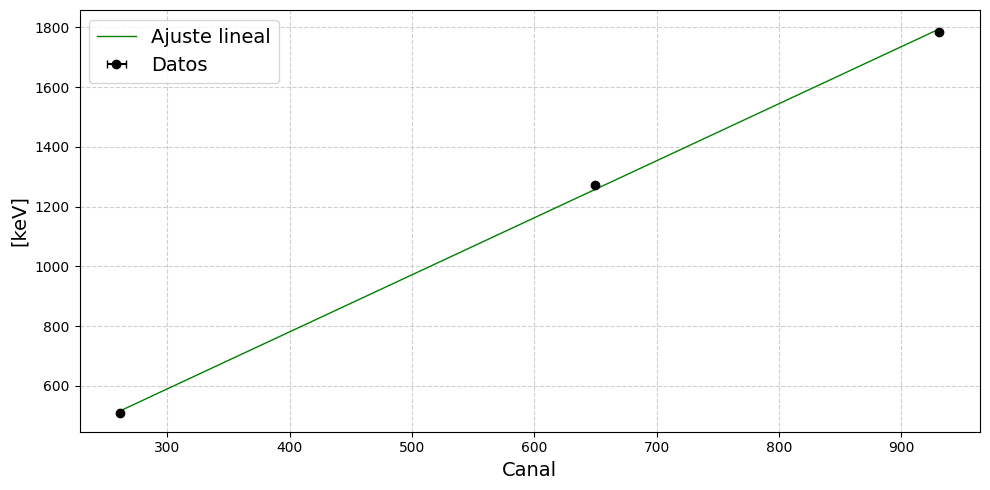

In [22]:
E = np.array([511, 1274, 1785])
mu = np.array([261.555, 650.02, 930.83])
dmu = np.array([0.021, 0.11, 0.16])
dE = np.ones_like(E)


def f(E, b0, b1):
    return b0 + b1 * E                                                                                # canal = b0 + b1 * energía

popt, pcov = curve_fit(f, E, mu, sigma=dE, absolute_sigma=True)
b0, b1 = popt
db0, db1 = np.sqrt(np.diag(pcov))

print("=== Ajuste de canal vs energía ===")
print(f"b0 = {b0:.3f} ± {db0:.3f}")
print(f"b1 = {b1:.5f} ± {db1:.5f}")
print(pcov[0,1])

# invierto
# E = a0 + a1 * canal
a1 = 1 / b1
a0 = -b0 / b1
da1 = db1 / b1**2
da0 = np.sqrt((db0/b1)**2 + (b0*db1/b1**2)**2)


def format_uncertainty(value, uncertainty):
    n_decimals = int(-np.floor(np.log10(uncertainty))) + 1
    value_rounded = round(value, n_decimals)
    uncertainty_rounded = round(uncertainty, n_decimals)
    digits = str(uncertainty_rounded).replace('.', '')[:3]
    return f"{value_rounded:.{n_decimals}f}({digits})"

a0_str = format_uncertainty(a0, da0)
a1_str = format_uncertainty(a1, da1)

print("\n=== Resultados de la calibración en energía ===")
print(f"a0 = {a0_str} keV")
print(f"a1 = {a1_str} keV/canal")
print(f"\nEcuación de calibración:")
print(f"E = {a0_str} + {a1_str} * canal")


plt.figure(figsize=(10,5))
plt.errorbar(mu, E, xerr=dmu, fmt='o', color='black', capsize=3, label='Datos')
plt.plot(mu, a0 + a1*mu, color='green', lw=1, label='Ajuste lineal')
plt.xlabel('Canal', fontsize=14)
plt.ylabel('[keV]', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


E_ajustado = a0 + a1 * mu
dif = E - E_ajustado
error_rel = np.abs(dif / E) * 100

# print("\n=== Comparación Energía Teórica vs Ajustada ===")
# print(f"{'Canal':>8} {'E_teórico (keV)':>18} {'E_ajustado (keV)':>20} {'ΔE (keV)':>12} {'Error %':>10}")
# for i in range(len(E)):
#     print(f"{mu[i]:8.2f} {E[i]:18.3f} {E_ajustado[i]:20.3f} {dif[i]:12.3f} {error_rel[i]:10.3f}")

In [ ]:
# cambio de acuerdo a lo que salga de la calibración de energía
canal = 75
a0 = 12
a1 = 13
E = a0 + a1 * canal
print(E)

# Eje x en keV

<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:24: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-275895201.py:23: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$E_\gamma$ [keV]", fontsize=14)
/tmp/ipython-input-275895201.py:24: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)


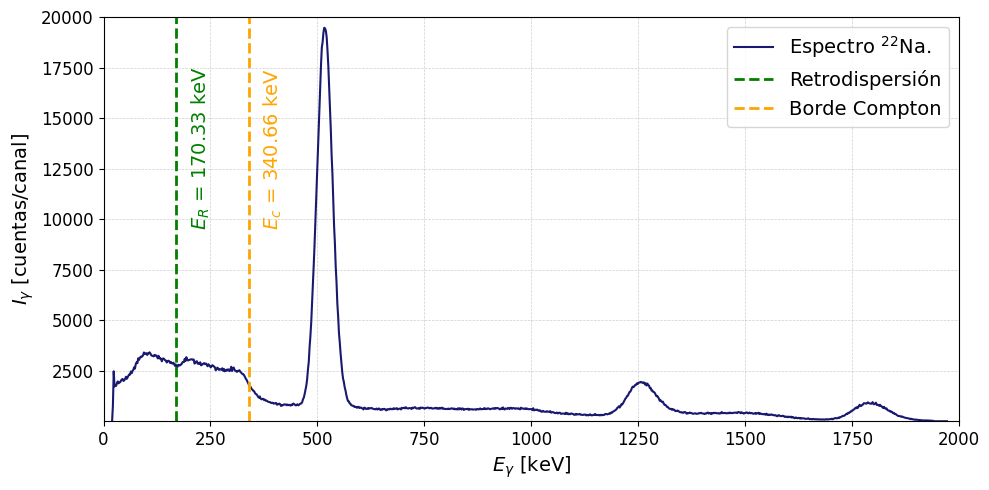

In [73]:
datos = "22Na-previa2.csv"
df = pd.read_csv(datos)

canal = df.iloc[:, 0]
cuentas = df.iloc[:, 1]

# cambiar de acuerdo a la calibración que extraiga

a0 = 18.1     # keV
a1 = 1.9081   # keV/canal

energia = a0 + a1 * canal   # conversión canal → keV

# según los cálculos teóricos
retro = 170.33
borde = 340.66

plt.figure(figsize=(10,5))
plt.plot(energia, cuentas, color='midnightblue', lw=1.5, label='Espectro $^{22}$Na.')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
# plt.yscale('log') # el punto pide que sea lineal en ambos ejes.
plt.xlabel("$E_\gamma$ [keV]", fontsize=14)
plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
plt.axvline(x=retro, color='green', lw=2, linestyle='--', label='Retrodispersión')
plt.axvline(x=borde, color='orange', lw=2,linestyle='--', label='Borde Compton')
plt.text(retro + 30, max(y)*0.5, f'$E_R$ = {retro} keV', color='green', rotation=90, fontsize=14)
plt.text(borde + 30, max(y)*0.5, f'$E_c$ = {borde} keV', color='orange', rotation=90, fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(fontsize=14)
plt.xlim(0,2000)
plt.ylim(1, 20000)
plt.tight_layout()
plt.show()

#Restar el fondo de los espectros

<>:34: SyntaxWarning: invalid escape sequence '\g'
<>:34: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2704651822.py:34: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)


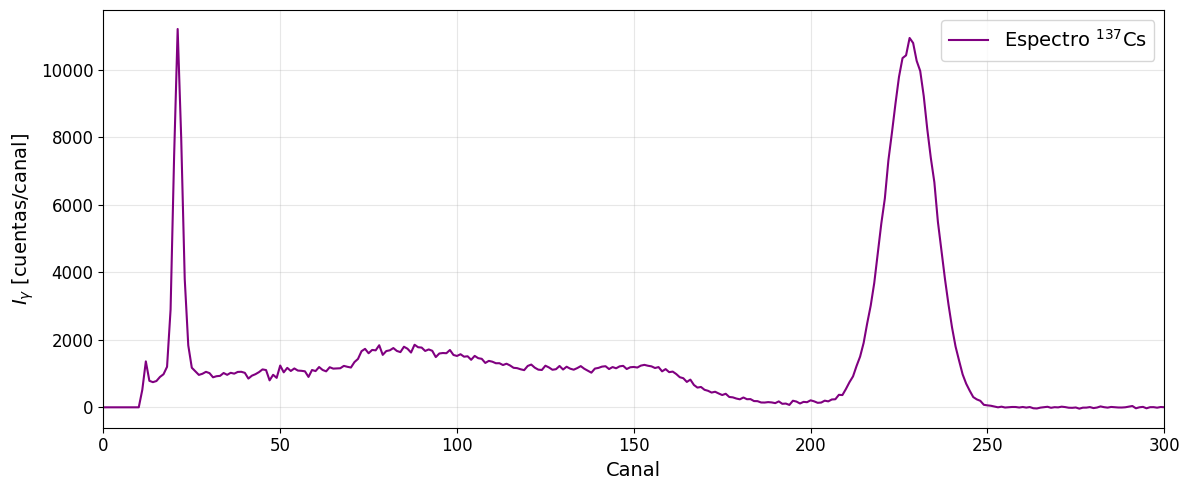

In [84]:
def leer_dat(archivo):
    with open(archivo, 'r', encoding='latin-1') as f:
        lineas = f.readlines()
    lineas_numericas = [l for l in lineas if l.strip() and l.strip()[0].isdigit()]

    data = pd.read_csv(StringIO(''.join(lineas_numericas)), sep=r'\s+', header=None)
    data.columns = ['canal', 'cuentas']
    return data

archivos = ["137Cs-previa2.dat"]
colores = ['purple']
etiquetas = ['Espectro $^{137}$Cs']

fondo_data = leer_dat("fondo-previa2.dat")
cuentas_fondo = fondo_data['cuentas'].astype(float).values

plt.figure(figsize=(12, 5))

for archivo, color, etiqueta in zip(archivos, colores, etiquetas):

    data = leer_dat(archivo)
    x = data['canal'].values
    y = data['cuentas'].astype(float).values

    if len(y) != len(cuentas_fondo):
        print(f"ERROR: El espectro {archivo} ({len(y)} puntos) y el fondo ({len(cuentas_fondo)} puntos) NO están alineados.")
        continue

    y_corregido = y - cuentas_fondo

    plt.plot(x, y_corregido, lw=1.5, color=color, label=etiqueta)

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
plt.xlim(0, 300)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Ajuste gaussiano
(otra vez pero con energía)


μ        = 21.074(27)
σ        = 1.157(31)
FWHM     = 2.715(72)
Int      = 28953(98)


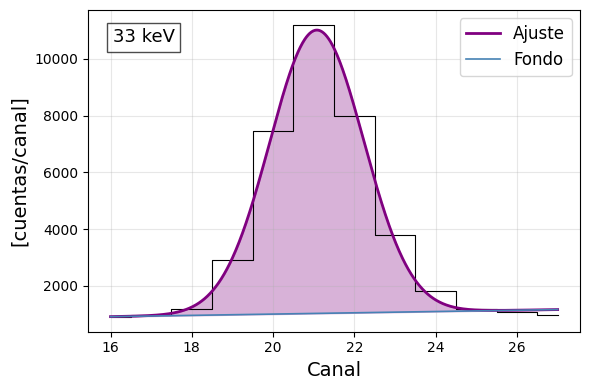


μ        = 228.115(24)
σ        = 6.860(29)
FWHM     = 16.092(68)
Int      = 183868(95)


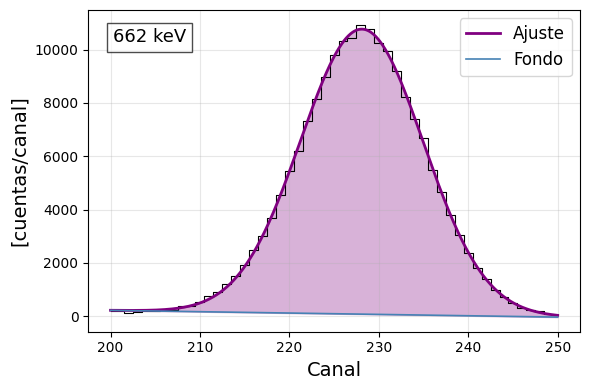

In [96]:
def leer_dat(archivo):
    try:
        with open(archivo, 'r', encoding='latin-1') as f:
            lineas = f.readlines()

        lineas_numericas = [l for l in lineas if l.strip() and l.strip()[0].isdigit()]

        data = pd.read_csv(StringIO(''.join(lineas_numericas)), sep=r'\s+', header=None)

        data.columns = ['canal', 'cuentas']
        return data.iloc[:, :2]
    except FileNotFoundError:
        print(f"Error: El archivo '{archivo}' no se encontró.")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error al leer el archivo {archivo}: {e}")
        return pd.DataFrame()

def gauss_bg(x, mu, sigma, A, a0, a1):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x

def fwhm(sigma): return 2.3458 * sigma
def dfwhm(dsigma): return 2.3458 * dsigma
def intensidad(A, sigma): return A * sigma * np.sqrt(2*np.pi)
def dintensidad(A, sigma, dA, dsigma):
    return np.sqrt((sigma*np.sqrt(2*np.pi)*dA)**2 + (A*np.sqrt(2*np.pi)*dsigma)**2)

def format_unc(value, error):
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

def ajustar_pico(x, y, x_min, x_max, color="purple", energia_keV=None):

    x_series = pd.Series(x)
    y_series = pd.Series(y)

    mask = (x_series >= x_min) & (x_series <= x_max)
    xr, yr = x_series[mask], y_series[mask]

    mu_guess = xr.iloc[np.argmax(yr)]
    A_guess = yr.max()
    p0 = [mu_guess, 4.0, A_guess, np.median(yr), 0.0]
    popt, pcov = curve_fit(gauss_bg, xr.values, yr.values, p0=p0, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))

    mu, sigma, A, a0, a1 = popt
    dmu, dsigma, dA, da0, da1 = perr

    print(f"\n======")
    labels = ["μ", "σ", "FWHM", "Int"]
    vals   = [mu, sigma, fwhm(sigma), intensidad(A, sigma)]
    errs   = [dmu, dsigma, dfwhm(dsigma), dintensidad(A, sigma, dA, dsigma)]

    for l, v, e in zip(labels, vals, errs):
        print(f"{l:8s} = {format_unc(v, e)}")

    xf = np.linspace(xr.min(), xr.max(), 800)
    fit = gauss_bg(xf, *popt)
    bg  = a0 + a1 * xf

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(xr, yr, where='mid', color='black', lw=0.8)
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    if energia_keV is not None:
        ax.text(
                0.05, 0.90,
                f"{energia_keV} keV",
                transform=ax.transAxes,
                fontsize=13,
                color="black",
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
            )

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("[cuentas/canal]", fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)


    plt.tight_layout()
    plt.show()

datos = "137Cs-previa2.dat"
nombre_archivo_fondo = "fondo-previa2.dat"

# Carga del espectro principal
df_espectro = leer_dat(datos)
# Carga del espectro de fondo
df_fondo = leer_dat(nombre_archivo_fondo)


if df_espectro.empty or df_fondo.empty:
    print("No se pudo cargar uno o ambos archivos de datos. Deteniendo el procesamiento.")
else:
    x = df_espectro['canal'].values
    y = df_espectro['cuentas'].values
    cuentas_fondo = df_fondo['cuentas'].values

    # **Verificación y Resta de Fondo**
    if len(y) != len(cuentas_fondo):
        print("ERROR: El número de canales del espectro y del fondo NO COINCIDE. Se requiere interpolación.")
        y_corregido = y
    else:

        y_corregido = y - cuentas_fondo

    y = y_corregido
    picos = [
        (16, 27, "purple", 33),
        (200, 250, "purple", 662),
    ]

    for xmin, xmax, color, energia in picos:
        ajustar_pico(x, y, xmin, xmax, color, energia)